<a href="https://colab.research.google.com/github/jmlDC/MediaBias-Thesis22-23/blob/PostAnnotation/Notebooks/Public_Scraper_on_Select_Media_Outlet_%5BMARISOL_study%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Media Outlet Scraper

Developed by: Dela Cruz, Jose Mari Luis


Last Maintained: Oct 9, 2023

This notebook save files in Google drive. If you want to change the file directory, just change the "dir" variable.

This notebook scrapes article of select Media outlet.

What it does is it collects the links of news articles for each visit of media outlet website (site scraper). Then from the list of links, ot scrapes the article information (article scraper).

Change website url accordingly, adn number of interactions according (pages, scrolls, clicks).

# Setting up Environment

## PIP install

## Imports

In [28]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium

# Install xvfb
apt install -y xvfb

# Install Selenium-Profiles
pip uninstall -y selenium_profiles -qq
pip install --no-cache-dir selenium_profiles>=2.2.6 -qq

# pip install https://github.com/kaliiiiiiiiii/Selenium-Profiles/archive/refs/heads/dev.zip # dev-branch

# install python packages
pip install google-colab-shell -qq
pip install webdriver-manager -qq
pip install Pyvirtualdisplay -qq

Executing: /tmp/apt-key-gpghome.ISYaTnxZzx/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
gpg: key DCC9EFBF77E11517: public key "Debian Stable Release Key (10/buster) <debian-release@lists.debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.o0lJ9oHifs/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
gpg: key DC30D7C23CBBABEE: public key "Debian Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.IYrfvZiB6a/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A
gpg: key 4DFAB270CAA96DFA: public key "Debian Security Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 http://deb.debian.org/debian buster InRelease [122 kB]
Get:2 http://security.ubuntu.com/ubuntu

In [1]:
import urllib.request,sys,time
from bs4 import BeautifulSoup
import requests
import pandas as pd
from datetime import date
import re

## Mounting to GDrive

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### dir variable

In [6]:
#  Change this dir if needed
dir  = "/content/gdrive/MyDrive/"

# Preperation Scrape



Functions needed to do the scraping



## Extract Source Function

In [7]:
def extract_source(url):
    agent = {"User-Agent":"Chrome/105.0.0.0"}
    try:
      source=requests.get(url, headers=agent)
    except Exception as e:                                   # this describes what to do if an exception is thrown
      error_type, error_obj, error_info = sys.exc_info()      # get the exception information
      print ('ERROR FOR LINK:',url)                          #print the link that cause the problem
      print (error_type, 'Line:', error_info.tb_lineno)     #print error info and line that threw the exception

    return source                                               #ignore this page. Abandon this and go back.

## Chrome driver

In [8]:
# https://colab.research.google.com/github/kaliiiiiiiiii/Selenium-Profiles/blob/master/google-colab/selenium_profiles.ipynb#scrollTo=lThF-0LvpZf3
## @title Start actual driver
from selenium_profiles.webdriver import Chrome
# from selenium_profiles.profiles import profiles
from selenium.webdriver.common.by import By
from selenium_profiles.utils.colab_utils import display, showscreen, show_html # virtual display
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, ElementNotVisibleException, ElementNotSelectableException
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager

!apt update
!apt install chromium-chromedriver
!pip install selenium

# set options to be headless, ..
from selenium import webdriver

def startChromeDriver():

    options = webdriver.ChromeOptions()
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    # open it, go to a website, and get results
    wd = webdriver.Chrome(options=options)
    return wd # results


Hit:1 http://deb.debian.org/debian buster InRelease
Hit:2 http://deb.debian.org/debian buster-updates InRelease
Hit:3 http://deb.debian.org/debian-security buster/updates InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:10 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state info




# MAIN Scraping

## GMA

### site scraper

https://www.gmanetwork.com/news/archives/news-nation/
scrolling 0


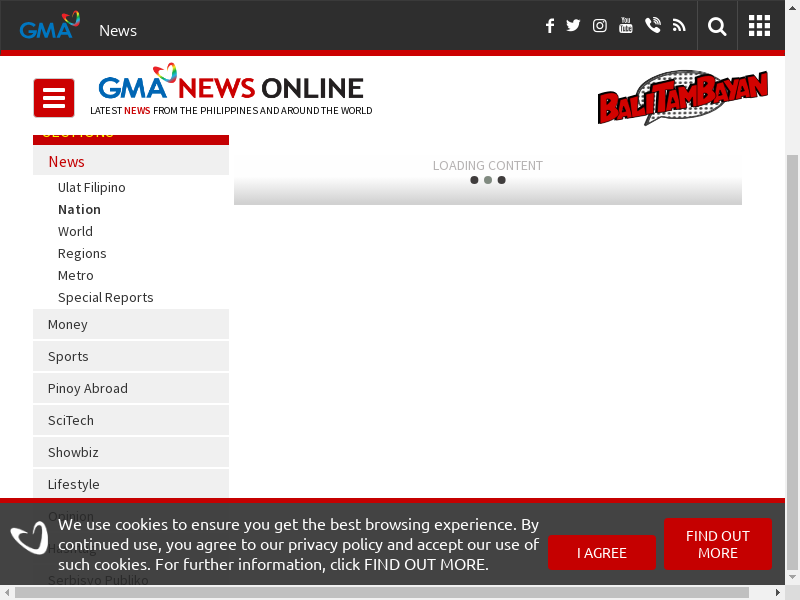

scrolling 1


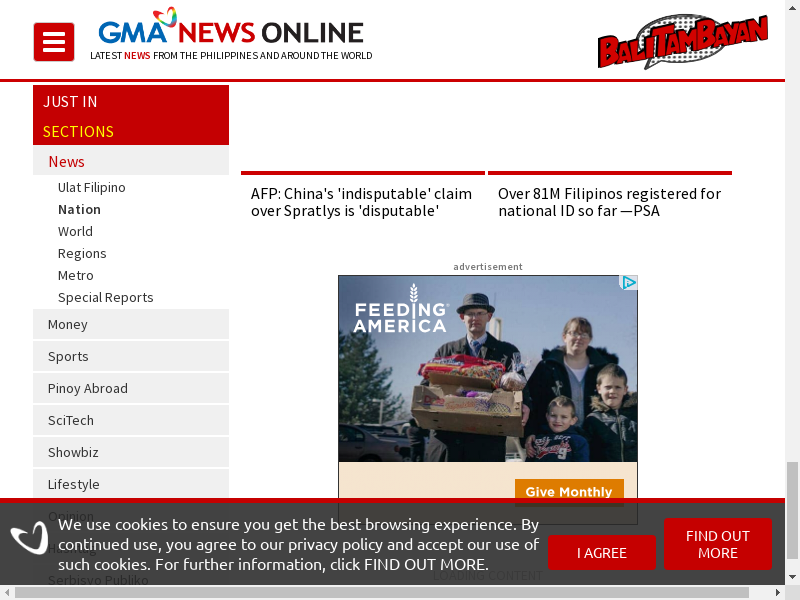

44


<ipython-input-25-0e369df89f4c>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmadata = gmadata.append(pd.Series(df_new_row, index=gmadata.columns[:len(df_new_row)]), ignore_index=True)
<ipython-input-25-0e369df89f4c>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmadata = gmadata.append(pd.Series(df_new_row, index=gmadata.columns[:len(df_new_row)]), ignore_index=True)
<ipython-input-25-0e369df89f4c>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmadata = gmadata.append(pd.Series(df_new_row, index=gmadata.columns[:len(df_new_row)]), ignore_index=True)
<ipython-input-25-0e369df89f4c>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

,Statement,Link,Date
0,JV Ejercito seeks hike in NBI's confi funds fo...,https://www.gmanetwork.com/news/topstories/nat...,"Oct 09, 2023"
1,Barbers: P30B illegal drugs seized since start...,https://www.gmanetwork.com/news/topstories/nat...,"Oct 09, 2023"
2,Marcos says bypass project to boost farming in...,https://www.gmanetwork.com/news/topstories/nat...,"Oct 09, 2023"
3,PhilHealth calls for public cooperation amid d...,https://www.gmanetwork.com/news/topstories/nat...,"Oct 08, 2023"
4,"Lawmakers call for end to violence in Israel, ...",https://www.gmanetwork.com/news/topstories/nat...,"Oct 08, 2023"


In [25]:
# https://www.gmanetwork.com/news/archives/news-nation
# https://stackoverflow.com/questions/20986631/how-can-i-scroll-a-web-page-using-selenium-webdriver-in-python
# https://gist.github.com/korakot/5c8e21a5af63966d80a676af0ce15067

url = 'https://www.gmanetwork.com/news/archives/news-nation/'    #Change this if you want
numScroll = 2                                                 #Change this if you want

site = "GMA"
gmadata=pd.DataFrame(columns=['Statement','Link','Date'])
print(url)

driver = startChromeDriver()
driver.get(url)


linksL, linksR,links = [],[],[]

cnt = 0
try:
    SCROLL_PAUSE_TIME = 7          #Change this if you want

    # Get scroll height
    last_height = driver.execute_script("return document.body.scrollHeight")
    while cnt <numScroll:
        print('scrolling', cnt)
        # Scroll down to bottom
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        showscreen(driver)
        # Wait to load page
        time.sleep(SCROLL_PAUSE_TIME)
        # Calculate new scroll height and compare with last scroll height
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height
        cnt += 1

    time.sleep(10)
    driver.implicitly_wait(10)
    WebDriverWait(driver, timeout=30).until(EC.visibility_of_element_located((By.XPATH, '//*[@id="grid_thumbnail_stories"]/li/div')))
    source = driver.page_source
    soup = BeautifulSoup(source, 'html.parser')

    time.sleep(10)

    linksL+=soup.find("ul", {'id' : 'grid_thumbnail_stories'}).find_all('li', {'class':'story left-grid'})
    linksR+=soup.find("ul", {'id' : 'grid_thumbnail_stories'}).find_all('li', {'class':'story right-grid'})
    links += linksL + linksR
    print(len(links))

    for j in links:
        Statement = j.find('div').find('div', {'class': 'story'}).find('div', {'class': 'story_title_holder'}).find('div', {'class' : 'story_title'}).text[:-21].strip()
        Link = j.find('a')['href'].strip()
        Date = j.find('div', {'class' : 'story_title_holder'}).find('div', {'class' : 'story_title'}).find('div', {'class': 'archive_date_time'}).text[:-8].strip()
        df_new_row = { 'Statement': Statement, 'Link': Link, 'Date': Date}
        gmadata = gmadata.append(pd.Series(df_new_row, index=gmadata.columns[:len(df_new_row)]), ignore_index=True)

except Exception as e:
    error_type, error_obj, error_info = sys.exc_info()
    print ('ERROR FOR LINK:',url)
    print (error_type, 'Line:', error_info.tb_lineno)



filename= f"{dir}{site}_{date.today()}_NEWS_LinkList.csv"

driver.quit()

gmadata.drop_duplicates(inplace=True)
gmadata.reset_index(drop=True)

gmadata.to_csv(filename)
gmadata.head()

In [23]:
gmadata.reset_index(drop=True, inplace=True)
# Save file
# gmadata.to_csv(filename)

### artricle scraper

In [30]:
def gmaArticleScraper(url):
    try:
        soup=BeautifulSoup(extract_source(url).text, 'html.parser')
        row=[]

        Title = soup.find('h1',{'class':'story_links'}).text.strip()
        try:
            Author = soup.find('div',attrs={'class':'main-byline'}).find('div').find('div').text.strip()
        except AttributeError:
            Author = ""

        try:
            Date = soup.find('div', attrs={'class': 'article-time'}).find('time')['datetime'][:10].strip()
        except Exception as e:
            error_type, error_obj, error_info = sys.exc_info()
            print ('ERROR FOR LINK:',url)
            print (error_type, 'Line:', error_info.tb_lineno)
            Date = ""

        textList =soup.find("div", {'class' :'story_main'}).find_all("p")
        body = ""
        for t in textList:
            if (t.find('p', class_="ad")):
                pass
            else:
                body += (t.text) +"\n"
        row.extend((Title, Author, Date, body))

    except Exception as e:
        error_type, error_obj, error_info = sys.exc_info()
        print ('ERROR FOR LINK:',url)
        print (error_type, 'Line:', error_info.tb_lineno)
    return row

site = "GMA"
gmadata2 = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
filename= f"{dir+site}_{date.today()}NEWS.csv"

df = pd.read_csv(f'{dir}{site}_{date.today()}_NEWS_LinkList.csv')     #Change this accordingly
for index, r in df.iterrows():
  url = r["Link"]
  print(index, url)
  row = gmaArticleScraper(url)
  gmadata2 = gmadata2.append(pd.Series(row, index=gmadata2.columns[:len(row)]), ignore_index=True)

# Save file
gmadata2.to_csv(filename)
gmadata2.head()

0 https://www.gmanetwork.com/news/topstories/nation/884626/jv-ejercito-seeks-hike-in-nbi-s-confi-funds-for-2024/story/
1 https://www.gmanetwork.com/news/topstories/nation/884617/barbers-p30b-illegal-drugs-seized-since-start-of-marcos-admin/story/
2 https://www.gmanetwork.com/news/topstories/nation/884614/marcos-says-bypass-project-to-boost-farming-industry-in-bulacan/story/
3 https://www.gmanetwork.com/news/topstories/nation/884580/philhealth-calls-for-public-cooperation-amid-data-breach/story/
4 https://www.gmanetwork.com/news/topstories/nation/884563/lawmakers-call-for-end-to-violence-in-israel-safety-of-filipinos/story/
5 https://www.gmanetwork.com/news/topstories/nation/884558/piston-seeks-junking-of-oil-deregulation-law/story/
6 https://www.gmanetwork.com/news/topstories/nation/884548/palace-condemns-attacks-on-israel-conveys-condolences-over-deaths/story/
7 https://www.gmanetwork.com/news/topstories/nation/884536/comelec-over-5k-show-cause-orders-issued-vs-erring-bske-bets/story/

,Title,Author,Date,Text
0,JV Ejercito seeks hike in NBI's confi funds fo...,"By HANA BORDEY, GMA Integrated News",2023-10-09,The National Bureau of Investigation’s (NBI) ...
1,Barbers: P30B illegal drugs seized since start...,"By LLANESCA T. PANTI, GMA Integrated News",2023-10-09,The amount of illegal drugs seized by authori...
2,Marcos says bypass project to boost farming in...,,2023-10-09,"President Ferdinand ""Bongbong"" Marcos Jr. sai..."
3,PhilHealth calls for public cooperation amid d...,"By SHERYLIN UNTALAN, GMA Integrated News",2023-10-08,"Because of the September 22, 2023 ransomware ..."
4,"Lawmakers call for end to violence in Israel, ...","By SHERYLIN UNTALAN, GMA Integrated News",2023-10-08,Philippine lawmakers on Sunday condemned the ...


## Rappler

### site scraper

In [27]:
# https://www.rappler.com/nation/national-news/
site = "Rappler"
rapplerData=pd.DataFrame(columns=['Statement','Link','Date'])

pagesToGet= 3      #Change this accordingly
driver = startChromeDriver()

for page in range(1,pagesToGet+1):
    print('processing page :', page)
    url = 'https://www.rappler.com/nation/national-news/page/'+str(page)+'/'         #Change this accordingly
    print(url)
    driver.get(url)
    driver.implicitly_wait(10)

    source = driver.page_source
    WebDriverWait(driver, 30).until(EC.visibility_of_element_located((By.CLASS_NAME, 'post-card__more')))
    soup = BeautifulSoup(source, 'html.parser')
    links = soup.find_all('div',attrs={'class':'post-card__more-secondary-story'})
    print(len(links))

    filename= f"{dir}{site}_{date.today()}_NEWS_LinkList.csv"                #Change this accordingly

    for j in links:
        Statement = j.find('h3', {'class' : 'post-card__title'}).find('a').text.strip()
        Link = j.find("h3", {'class' : 'post-card__title'}).find('a')['href'].strip()
        Date = j.find('time')['datetime'][:10].strip()
        df_new_row = { 'Statement': Statement, 'Link': Link, 'Date': Date}
        rapplerData = rapplerData.append(pd.Series(df_new_row, index=rapplerData.columns[:len(df_new_row)]), ignore_index=True)

driver.quit()
rapplerData.drop_duplicates(inplace=True)
# Save file
rapplerData.to_csv(filename)
rapplerData.head()

processing page : 1
https://www.rappler.com/nation/national-news/page/1/
5
processing page : 2
https://www.rappler.com/nation/national-news/page/2/


<ipython-input-27-26e9daaef46f>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rapplerData = rapplerData.append(pd.Series(df_new_row, index=rapplerData.columns[:len(df_new_row)]), ignore_index=True)
<ipython-input-27-26e9daaef46f>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rapplerData = rapplerData.append(pd.Series(df_new_row, index=rapplerData.columns[:len(df_new_row)]), ignore_index=True)
<ipython-input-27-26e9daaef46f>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rapplerData = rapplerData.append(pd.Series(df_new_row, index=rapplerData.columns[:len(df_new_row)]), ignore_index=True)
<ipython-input-27-26e9daaef46f>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

4
processing page : 3
https://www.rappler.com/nation/national-news/page/3/


<ipython-input-27-26e9daaef46f>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rapplerData = rapplerData.append(pd.Series(df_new_row, index=rapplerData.columns[:len(df_new_row)]), ignore_index=True)
<ipython-input-27-26e9daaef46f>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rapplerData = rapplerData.append(pd.Series(df_new_row, index=rapplerData.columns[:len(df_new_row)]), ignore_index=True)
<ipython-input-27-26e9daaef46f>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rapplerData = rapplerData.append(pd.Series(df_new_row, index=rapplerData.columns[:len(df_new_row)]), ignore_index=True)
<ipython-input-27-26e9daaef46f>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

4


<ipython-input-27-26e9daaef46f>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rapplerData = rapplerData.append(pd.Series(df_new_row, index=rapplerData.columns[:len(df_new_row)]), ignore_index=True)
<ipython-input-27-26e9daaef46f>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rapplerData = rapplerData.append(pd.Series(df_new_row, index=rapplerData.columns[:len(df_new_row)]), ignore_index=True)
<ipython-input-27-26e9daaef46f>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rapplerData = rapplerData.append(pd.Series(df_new_row, index=rapplerData.columns[:len(df_new_row)]), ignore_index=True)
<ipython-input-27-26e9daaef46f>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

,Statement,Link,Date
0,Is it time to repeal the law that put drag art...,https://www.rappler.com/newsbreak/in-depth/is-...,2023-10-09
1,"DOE, BIR should seek arbiter over P18-billion ...",https://www.rappler.com/nation/coa-says-doe-bi...,2023-10-09
2,DOJ says PCSO not exempt from remitting divide...,https://www.rappler.com/nation/department-just...,2023-10-08
3,LOOK: Climate Justice Walk to remember 10th an...,https://www.rappler.com/nation/photos-climate-...,2023-10-08
4,Philippines condemns attacks by Hamas on Israe...,https://www.rappler.com/nation/philippines-con...,2023-10-08


### artricle scraper

In [32]:
def rapplerArticleScraper(url):
  try:
    soup=BeautifulSoup(extract_source(url).text, 'html.parser')

    row=[]
    Title = soup.find('h1',{'class':'post-single__title'}).text.strip()
    try:
        Author = soup.find('div', attrs={'class': 'post-single__authors'}).text.strip()
    except AttributeError:
        Author = ""
    try:
        Date = soup.find('time')['datetime'][:10].strip()
    except Exception as e:
      error_type, error_obj, error_info = sys.exc_info()
      print ('ERROR FOR LINK:',url)
      print (error_type, 'Line:', error_info.tb_lineno)
      Date = ""

    textList =soup.find("div", {'class' :'post-single__content entry-content'}).find_all("p")
    body = ""
    for t in textList:
        body += (t.text) +"\n"
    row.extend((Title, Author, Date, body))

  except Exception as e:
      error_type, error_obj, error_info = sys.exc_info()
      print ('ERROR FOR LINK:',url)
      print (error_type, 'Line:', error_info.tb_lineno)
  return row

site = "Rappler"
rapplerData2 = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
filename= f"{dir+site}_{date.today()}NEWS.csv"

df = pd.read_csv(f'{dir}{site}_{date.today()}_NEWS_LinkList.csv')       #Change this accordingly
for index, r in df.iterrows():
  url = r["Link"]
  print(index, url)
  row = rapplerArticleScraper(url)
  rapplerData2 = rapplerData2.append(pd.Series(row, index=rapplerData2.columns[:len(row)]), ignore_index=True)

#  Save File
rapplerData2.to_csv(filename)
rapplerData2

0 https://www.rappler.com/newsbreak/in-depth/is-it-time-repeal-law-put-drag-artist-pura-luka-vega-behind-bars/
1 https://www.rappler.com/nation/coa-says-doe-bir-arbiter-billion-pesos-excise-tax-dispute/
2 https://www.rappler.com/nation/department-justice-pcso-not-exempt-remitting-dividends-national-treasury/
3 https://www.rappler.com/nation/photos-climate-justice-walk-2023/
4 https://www.rappler.com/nation/philippines-condemns-attacks-hamas-on-israel-october-8-2023/
5 https://www.rappler.com/nation/liberal-party-statement-confidential-funds-controversy-stella-quimbo-remains-party-member/
6 https://www.rappler.com/nation/courts-junk-murder-cases-vs-elderly-man-mistaken-fugitive/
7 https://www.rappler.com/nation/mayors-good-governance-statement-2024-national-budget/
8 https://www.rappler.com/nation/china-faces-global-isolation-irresponsible-actions-west-philippine-sea/
9 https://www.rappler.com/nation/father-xavier-olin-13th-provincial-superior-society-of-jesus-philippines/
10 https://ww

,Title,Author,Date,Text
0,Is it time to repeal the law that put drag art...,Jairo Bolledo,2023-10-09,"MANILA, Philippines – Art is liberation for ma..."
1,"DOE, BIR should seek arbiter over P18-billion ...",Rappler.com,2023-10-09,"MANILA, Philippines – State auditors ruled tha..."
2,DOJ says PCSO not exempt from remitting divide...,Rappler.com,2023-10-08,"MANILA, Philippines – The Philippine Charity S..."
3,LOOK: Climate Justice Walk to remember 10th an...,Rappler.com,2023-10-08,"MANILA, Philippines – Forty climate advocates ..."
4,Philippines condemns attacks by Hamas on Israe...,Bonz Magsambol,2023-10-08,"MANILA, Philippines – The Philippines on Sunda..."
5,Despite her defense of Sara Duterte’s confiden...,Jairo Bolledo,2023-10-07,"MANILA, Philippines – Despite the involvement ..."
6,Courts junk murder cases vs elderly man mistak...,Jairo Bolledo,2023-10-07,"MANILA, Philippines – Taguig courts have junke..."
7,Redirect ‘unnecessary expenditures’ in propose...,Lance Spencer Yu,2023-10-07,"MANILA, Philippines – As confidential funds an..."
8,China faces ‘global isolation’ over ‘irrespons...,Rappler.com,2023-10-07,"MANILA, Philippines – China faces “global isol..."
9,Bicolano priest Fr. Xavier Olin is new Jesuit ...,Paterno R. Esmaquel II,2023-10-07,"MANILA, Philippines – A 49-year-old Bicolano p..."


## Sunstar Philippines

### site scraper

In [34]:
# https://www.sunstar.com.ph/morearticles/manila/local-news?pgno=1
# https://www.sunstar.com.ph/morearticles/davao/local-news
# https://www.sunstar.com.ph/morearticles/cebu/local-news
# https://www.sunstar.com.ph/morearticles/pampanga/local-news

places = ['manila', 'cebu', 'davao', 'pampanga']

site = "SunStar"
filename= f"{dir}{site}_{date.today()}_NEWS_LinkList.csv"
starData=pd.DataFrame(columns=['Statement','Link','Date'])
driver = startChromeDriver()
pagesToGet= 3                                                   #Change this accordingly
for place in places:
    for page in range(1,pagesToGet+1):
        print('processing page :', page, place)
        url = 'https://www.sunstar.com.ph/morearticles/'+place+'/local-news?pgno='+str(page)     #Change this accordingly
        print(url)


        driver.get(url)
        source = driver.page_source
        soup = BeautifulSoup(source, 'html.parser')
        links = soup.find_all('div',attrs={'class':'article-info'})
        print(len(links))


        for j in links:
            try:
                Statement = j.find('h2', {'class' : 'article-title'}).find('a').text.strip()
                Link = j.find('h2', {'class' : 'article-title'}).find('a')['href'].strip()
                Date = j.find('div', {'class': 'article-date'}).text.strip()
                df_new_row = { 'Statement': Statement, 'Link': Link, 'Date': Date}
                starData = starData.append(pd.Series(df_new_row, index=starData.columns[:len(df_new_row)]), ignore_index=True)
            except Exception as e:
                error_type, error_obj, error_info = sys.exc_info()
                print ('ERROR FOR LINK:',url)
                print (error_type, 'Line:', error_info.tb_lineno)

driver.quit()
print(starData.shape)
starData.drop_duplicates(inplace=True)

#  Save File
starData.to_csv(filename)
starData.head()

processing page : 1 manila
https://www.sunstar.com.ph/morearticles/manila/local-news?pgno=1
20
processing page : 2 manila
https://www.sunstar.com.ph/morearticles/manila/local-news?pgno=2
20
processing page : 3 manila
https://www.sunstar.com.ph/morearticles/manila/local-news?pgno=3
20
processing page : 1 cebu
https://www.sunstar.com.ph/morearticles/cebu/local-news?pgno=1
20
processing page : 2 cebu
https://www.sunstar.com.ph/morearticles/cebu/local-news?pgno=2
20
processing page : 3 cebu
https://www.sunstar.com.ph/morearticles/cebu/local-news?pgno=3
20
processing page : 1 davao
https://www.sunstar.com.ph/morearticles/davao/local-news?pgno=1
20
processing page : 2 davao
https://www.sunstar.com.ph/morearticles/davao/local-news?pgno=2
20
processing page : 3 davao
https://www.sunstar.com.ph/morearticles/davao/local-news?pgno=3
20
processing page : 1 pampanga
https://www.sunstar.com.ph/morearticles/pampanga/local-news?pgno=1
20
processing page : 2 pampanga
https://www.sunstar.com.ph/morearti

,Statement,Link,Date
0,2 Filipinos injured in Israel attack,https://www.sunstar.com.ph/article/1975057/man...,"October 09, 2023"
1,Big-time rollback in fuel prices,https://www.sunstar.com.ph/article/1975052/man...,"October 09, 2023"
2,Philhealth members told: Be wary of fraudulent...,https://www.sunstar.com.ph/article/1975051/man...,"October 09, 2023"
3,Marcos to DA: Use enhancement fund to boost su...,https://www.sunstar.com.ph/article/1975050/man...,"October 09, 2023"
4,Actor Ricardo Cepeda arrested for syndicated e...,https://www.sunstar.com.ph/article/1974994/man...,"October 08, 2023"


### artricle scraper

In [35]:
def sunStarArticleScraper(url):
  row=[]
  try:
    soup = BeautifulSoup(extract_source(url).text, 'html.parser')

    time.sleep(1)
    Title = soup.find('h1',{'class':'title-article'}).text.strip()
    try:
        Author = soup.find('div', attrs={'class': 'article-byline'}).text.strip()
    except AttributeError:
        Author = ""

    try:
        Date = soup.find('div', {'class': 'article-date'}).text.strip()
    except Exception as e:
      error_type, error_obj, error_info = sys.exc_info()
      print ('ERROR FOR LINK:',url)
      print (error_type, 'Line:', error_info.tb_lineno)
      Date = ""

    body = soup.find('div', {'class': 'article-body'}).text.strip()
    row.extend((Title, Author, Date, body))

  except Exception as e:
      error_type, error_obj, error_info = sys.exc_info()
      print ('ERROR FOR LINK:',url)
      print (error_type, 'Line:', error_info.tb_lineno)

  return row

site = "SunStar"
starData2 = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
filename= f"{dir+site}_{date.today()}NEWS.csv"


df = pd.read_csv(f'{dir}{site}_{date.today()}_NEWS_LinkList.csv')                                #Change this accordingly
for index, r in df.iterrows():
  url = r["Link"]
  print(index, url)
  row = sunStarArticleScraper(url)
  starData2 = starData2.append(pd.Series(row, index=starData2.columns[:len(row)]), ignore_index=True)

#  Save File
starData2.to_csv(filename)
starData2.head()

0 https://www.sunstar.com.ph/article/1975057/manila/local-news/2-filipinos-injured-in-israel-attack
1 https://www.sunstar.com.ph/article/1975052/manila/local-news/big-time-rollback-in-fuel-prices
2 https://www.sunstar.com.ph/article/1975051/manila/local-news/philhealth-members-told-be-wary-of-fraudulent-activities
3 https://www.sunstar.com.ph/article/1975050/manila/local-news/marcos-to-da-use-enhancement-fund-to-boost-support-to-rice-farmers
4 https://www.sunstar.com.ph/article/1974994/manila/local-news/actor-ricardo-cepeda-arrested-for-syndicated-estafa
5 https://www.sunstar.com.ph/article/1974993/manila/local-news/marcos-orders-government-agencies-to-ensure-safety-of-filipinos-in-israel
6 https://www.sunstar.com.ph/article/1974988/manila/local-news/no-filipino-fatalities-reported-in-israel-attack
7 https://www.sunstar.com.ph/article/1974941/manila/local-news/10-more-dq-cases-filed-against-epal-bske-bets
8 https://www.sunstar.com.ph/article/1974940/manila/local-news/bishop-scores-lack

,Title,Author,Date,Text
0,2 Filipinos injured in Israel attack,Third Anne Peralta-Malonzo,"October 09, 2023",TWO Filipino nationals were confirmed to have ...
1,Big-time rollback in fuel prices,Third Anne Peralta-Malonzo,"October 09, 2023",OIL firms will implement a big-time rollback o...
2,Philhealth members told: Be wary of fraudulent...,Third Anne Peralta-Malonzo,"October 09, 2023",THE Philippine Health Insurance Corporation (P...
3,Marcos to DA: Use enhancement fund to boost su...,Third Anne Peralta-Malonzo,"October 09, 2023",PRESIDENT Ferdinand Marcos Jr. has ordered the...
4,Actor Ricardo Cepeda arrested for syndicated e...,Third Anne Peralta-Malonzo,"October 08, 2023",AUTHORITIES arrested actor Ricardo Cepeda over...


## Philippine News Agency

### site scraper

In [ ]:
# https://www.pna.gov.ph/categories/national

site = "PhilippineNewsAgency"
pnaData=pd.DataFrame(columns=['Statement','Link','Date'])

pagesToGet= 3                              #Change this accordingly
for page in range(1,pagesToGet+1):
    print('processing page :', page)
    url = 'https://www.pna.gov.ph/categories/national?p='+str(page)                                #Change this accordingly
    print(url)
    driver = startChromeDriver()
    driver.get(url)
    time.sleep(30)
    try:
        driver.implicitly_wait(30)
        WebDriverWait(driver, 60).until(EC.visibility_of_element_located((By.CLASS_NAME, 'articles')))

        source = driver.page_source
        soup = BeautifulSoup(source, 'html.parser')
        links = soup.find_all('div',attrs={'class':'article media'})
        print(len(links))
    except Exception as e:
      error_type, error_obj, error_info = sys.exc_info()
      print ('ERROR FOR LINK:',url)
      print (error_type, 'Line:', error_info.tb_lineno)

    filename= f"{dir}{site}_{date.today()}_NEWS_LinkList.csv"

    for j in links:
        try:
            Statement = j.find('h3', {'class' : 'media-heading'}).find('a').text.strip()
            Link = 'https://www.pna.gov.ph'+j.find('h3', {'class' : 'media-heading'}).find('a')['href'].strip()
            Date = j.find('span', {'class': 'date'}).text.strip()
            df_new_row = { 'Statement': Statement, 'Link': Link, 'Date': Date}
            pnaData = pnaData.append(pd.Series(df_new_row, index=pnaData.columns[:len(df_new_row)]), ignore_index=True)
        except Exception as e:
            error_type, error_obj, error_info = sys.exc_info()
            print ('ERROR FOR LINK:',url)
            print (error_type, 'Line:', error_info.tb_lineno)

driver.quit()
pnaData.drop_duplicates(inplace=True)

#Save file
pnaData.to_csv(filename)
pnaData.head()

processing page : 1
https://www.pna.gov.ph/categories/national?p=1


### artricle scraper

In [ ]:
def pnaArticleScraper(url):

  row=[]
  try:
    soup=BeautifulSoup(extract_source(url).text, 'html.parser')
    time.sleep(1)
    Title = soup.find('h1').text.strip()

    try:
        Author = soup.find('span', attrs={'class': 'd-block author mb-2'}).text.strip()
    except AttributeError:
        Author =''
    except Exception as e:
      error_type, error_obj, error_info = sys.exc_info()
      print ('ERROR FOR LINK:',url)
      print (error_type, 'Line:', error_info.tb_lineno)
      Author = ""

    try:
        Date = soup.find('div', {'class': 'col-sm-6 cell-1'}).find('span', {'class': 'date published'}).text[:-8].strip()[:-1]
    except Exception as e:
      error_type, error_obj, error_info = sys.exc_info()
      print ('ERROR FOR LINK:',url)
      print (error_type, 'Line:', error_info.tb_lineno)
      Date = ""
    textList = soup.find('div', {'class': 'page-content'}).find_all('p')
    body = ""
    for t in textList:
        body += (t.text) +"\n"
    row.extend((Title, Author, Date, body))

  except Exception as e:
      error_type, error_obj, error_info = sys.exc_info()
      print ('ERROR FOR LINK:',url)
      print (error_type, 'Line:', error_info.tb_lineno)

  return row

site = "PhilippineNewsAgency"
pnaData2 = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
filename= f"{dir+site}_{date.today()}NEWS.csv"

df = pd.read_csv(f'{dir}{site}_{date.today()}_NEWS_LinkList.csv')                                  #Change this accordingly
for index, r in df.iterrows():
  url = r["Link"]
  print(index, url)
  row = pnaArticleScraper(url)
  pnaData2 = pnaData2.append(pd.Series(row, index=pnaData2.columns[:len(row)]), ignore_index=True)

#Save file
pnaData2.to_csv(filename)
pnaData2.head()

## Manila Bulletin

https://www.scrapingbee.com/webscraping-questions/selenium/how-to-scroll-to-element-selenium/#:~:text=You%20can%20scroll%20to%20an,the%20execute_script%20as%20an%20argument.

### site scraper

In [41]:
## Manila bulletin
# News link getter for National News
# Simulate clicking the more button in MB site, and then extract all the news link

site = "manilaBulletin"
mbData = pd.DataFrame(columns=['Statement','Link','Date'])
url = 'https://mb.com.ph/category/national'                                #Change this accordingly
print(url)

driver = startChromeDriver()
driver.get(url)
driver.implicitly_wait(10)

moreClicks = 4                                                       #Change this accordingly
for x in range(moreClicks):
  try:
    js_code = "arguments[0].scrollIntoView();"
    # The WebElement you want to scroll to
    element = WebDriverWait(driver, timeout=5).until(EC.element_to_be_clickable((By.XPATH, '//*[@id="app"]/div/main/div/div/div/div[3]/div[2]/div[2]/div/div[2]/button')))
    # Execute the JS script
    driver.execute_script(js_code, element)
    element.click()
    print(x,'clicked')
  except Exception as e:
      error_type, error_obj, error_info = sys.exc_info()
      print ('ERROR FOR LINK:',url)
      print (error_type, 'Line:', error_info.tb_lineno)

source = driver.page_source

soup = BeautifulSoup(source, 'html.parser')
links=soup.find("div", {'class' : 'article-list mx-auto'}).find_all('div',attrs={'class':'row mb-5'})
print(len(links))

filename= f"{dir}{site}_{date.today()}_NEWS_LinkList.csv"

for j in links:
    Statement = j.find('h4', {'class' : 'mb-font-article-title mt-0 mb-1'}).find('a').text.strip()
    Link = "https://mb.com.ph"+j.find("h4", {'class' : 'mb-font-article-title mt-0 mb-1'}).find('a')['href'].strip()
    Date = j.find('div', {'class': 'ml-2'}).text.strip()
    df_new_row = { 'Statement': Statement, 'Link': Link, 'Date': Date}
    mbData = mbData.append(pd.Series(df_new_row, index=mbData.columns[:len(df_new_row)]), ignore_index=True)

driver.quit()
mbData.drop_duplicates(inplace=True)

#Save file
mbData.to_csv(filename)
mbData.head()

https://mb.com.ph/category/national
ERROR FOR LINK: https://mb.com.ph/category/national
<class 'selenium.common.exceptions.TimeoutException'> Line: 19
ERROR FOR LINK: https://mb.com.ph/category/national
<class 'selenium.common.exceptions.TimeoutException'> Line: 19
ERROR FOR LINK: https://mb.com.ph/category/national
<class 'selenium.common.exceptions.TimeoutException'> Line: 19
ERROR FOR LINK: https://mb.com.ph/category/national
<class 'selenium.common.exceptions.TimeoutException'> Line: 19
5


,Statement,Link,Date
0,IMF 'praised' establishment of Maharlika fund ...,https://mb.com.ph/2023/10/9/imf-praised-establ...,4 minutes ago
1,Naturalized Filipino athletes should enjoy sam...,https://mb.com.ph/2023/10/9/naturalized-filipi...,4 minutes ago
2,‘Where is the rice?’: Teachers prod NFA for pr...,https://mb.com.ph/2023/10/9/where-is-the-rice-...,16 minutes ago
3,ERC prescribes 2-tiered review process for auc...,https://mb.com.ph/2023/10/9/erc-prescribes-2-t...,20 minutes ago
4,UP Diliman launches 'Portia Sanctuary' to prom...,https://mb.com.ph/2023/10/9/up-diliman-launche...,29 minutes ago


### article scraper

In [42]:
# Article Reader from LINK
def manilabulletinArticleScraper(url):
    row=[]
    try:
        time.sleep(60)
        soup=BeautifulSoup(extract_source(url).text, 'html.parser')

        text=soup.find("div", {'class' : 'col-md-8 col-xl-8 col-12'})
        Title = text.find('h1',{'class':'pt-3 mb-font-article-title'}).text.strip()
        Author = text.find('div',attrs={'class':'mb-font-author-name overflow-nowrap'}).find('a').text.strip()
        Date = text.find('div', attrs={'class': 'pt-0'}).text[:-8]

        body = ""
        textList =  soup.find('div', {'class':'pt-8 custom-article-body mb-font-article-body'}).find_all('p')

        for t in textList:
            body += (t.text.replace('\u200b', '')) +"\n"
        row.extend((Title, Author, Date, body))

    except Exception as e:
        error_type, error_obj, error_info = sys.exc_info()
        print ('ERROR FOR LINK:',url)
        print (error_type, 'Line:', error_info.tb_lineno)
    return row

site = "manilaBulletin"
mbData2 = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
filename= f"{dir}{site}_{date.today()}_NEWS.csv"

df = pd.read_csv(f'{dir}{site}_{date.today()}_NEWS_LinkList.csv')
for index, r in df.iterrows():
    url = r["Link"]
    print(index, url)
    row = manilabulletinArticleScraper(url)
    mbData2 = mbData2.append(pd.Series(row, index=mbData2.columns[:len(row)]), ignore_index=True)

#Save file
mbData2.to_csv(filename)
mbData2.head()

0 https://mb.com.ph/2023/10/9/imf-praised-establishment-of-maharlika-fund-diokno
1 https://mb.com.ph/2023/10/9/naturalized-filipino-athletes-should-enjoy-same-rights-privileges-of-natural-born-players-tolentino-reminds-doj
2 https://mb.com.ph/2023/10/9/where-is-the-rice-teachers-prod-nfa-for-promised-one-time-assistance
3 https://mb.com.ph/2023/10/9/erc-prescribes-2-tiered-review-process-for-auctioned-power-supply-deals
4 https://mb.com.ph/2023/10/9/up-diliman-launches-portia-sanctuary-to-promote-mental-health-wellness


,Title,Author,Date,Text
0,IMF 'praised' establishment of Maharlika fund ...,Chino S. Leyco,"Oct 9, 2023",The Department of Finance (DOF) said the Inter...
1,Naturalized Filipino athletes should enjoy sam...,Hannah Torregoza,"Oct 9, 2023","Senator Francis Tolentino on Monday, October 9..."
2,‘Where is the rice?’: Teachers prod NFA for pr...,Merlina Hernando-Malipot,"Oct 9, 2023",A group of teachers expressed their concerns r...
3,ERC prescribes 2-tiered review process for auc...,Myrna M. Velasco,"Oct 9, 2023",The Energy Regulatory Commission (ERC) has pre...
4,UP Diliman launches 'Portia Sanctuary' to prom...,Rhowen Del Rosario,"Oct 9, 2023",The University of the Philippines Diliman (UP-...
